This notebook is to try out different architectures of NNs

In [ ]:
%reset

In [1]:
%run 'Functions.ipynb'

/home/katya/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# 1. Training NN for a single chunk

In [7]:
min_max_scaler = MinMaxScaler()
n_iter = 100

chunk = 'S5'
print (chunk)
data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

model = Sequential()

model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer=opt,
              loss='mean_squared_error',
              verbose=0)

hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                        epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

proba = model.predict_proba(data, batch_size=500, verbose=0)

weights[chunk] = model.layers[0].get_weights()[0]
biases[chunk] = model.layers[0].get_weights()[1]

true[chunk] = labels
predicted[chunk] = min_max_scaler.inverse_transform(proba)
predicted[chunk] = predicted[chunk].flatten()
fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S5


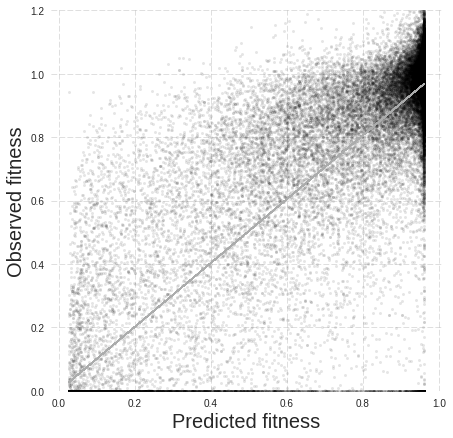

In [185]:
plt.figure(figsize = [7,7])
y = true[chunk]
x = predicted[chunk]
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=20)
plt.ylabel('Observed fitness', fontsize=20);

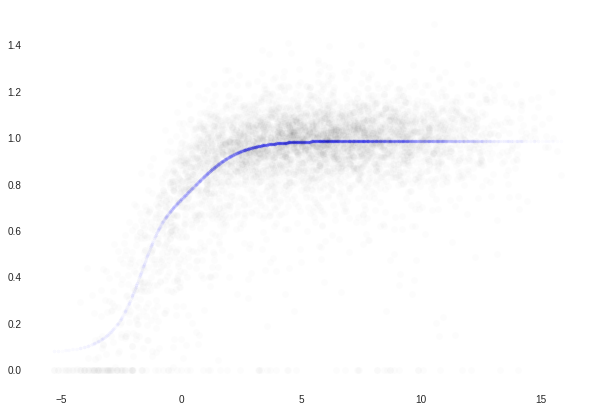

In [97]:
plt.figure(figsize = [10,7])
plt.plot(fitness_potential[chunk][:5000], true[chunk][:5000], 'ok', alpha = 0.01);
plt.plot(fitness_potential[chunk][:5000], predicted[chunk][:5000], '.b', alpha = 0.01);

***

In [74]:
_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
if R>0:
    fitness_potential[chunk]*=-1
    weights[chunk]*=-1

_,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
print chunk, '\t', R

S5 	-0.564778678286


### Selecting epistatic genotypes

In [583]:
chunk = 'S2'
data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

In [497]:
epi = pd.DataFrame.from_csv('../../lbcepistasisdropbox/' + chunk[1:] + '.tab', sep='\t')
epi['Mut'] = epi.VarPos.map(str) + epi.Perm

In [512]:
epistaticGenotypesPotential=[]
epistaticGenotypesFitness=[]

In [487]:
test = epi[(epi.Mut==list(set(epi.Mut))[7])&(epi.FitImpact>0)]
test = test.sort_values(by=['FitImpact'], ascending=False)

In [518]:
sq = 'SNRAFAVTKLGLQREKVGDLSSEMVPHV'
x = aa_seq[chunk]
ind = x[x==sq].index[0]
fp = data[ind].dot(weights[chunk])
f = labels[ind]
epistaticGenotypesPotential.append(fp)
epistaticGenotypesFitness.append(f)

In [511]:
for sq in test.Seq2[:100]:
    x = aa_seq[chunk]
    ind = x[x==sq].index[0]
    fp = data[ind].dot(weights[chunk])
    f = labels[ind]
    epistaticGenotypesPotential.append(fp)
    epistaticGenotypesFitness.append(f)

IndexError: index 0 is out of bounds for axis 0 with size 0

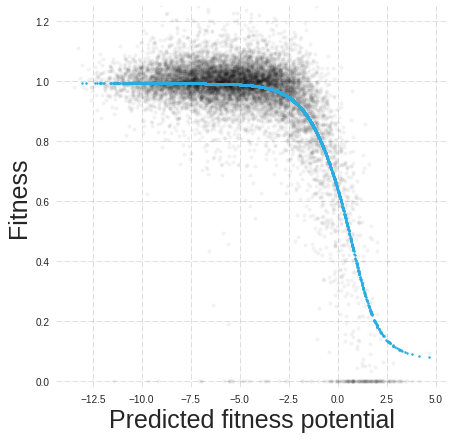

In [544]:
plt.figure(figsize = [7,7])
plt.plot(fitness_potential[chunk][:10000], true[chunk][:10000], 'ok', alpha = 0.05, ms=4);
plt.plot(fitness_potential[chunk][:5000], predicted[chunk][:5000], '.', color='#2AACE2', alpha = 1, ms=5)
# plt.plot(epistaticGenotypesPotential, epistaticGenotypesFitness,'o', color='#EA0A8C', alpha=0.8, ms=6)
plt.xlabel('Predicted fitness potential',fontsize=25)
plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.ylabel('Fitness',fontsize=25)
plt.ylim(-0.02,1.25);

In [578]:
chunk='S1'

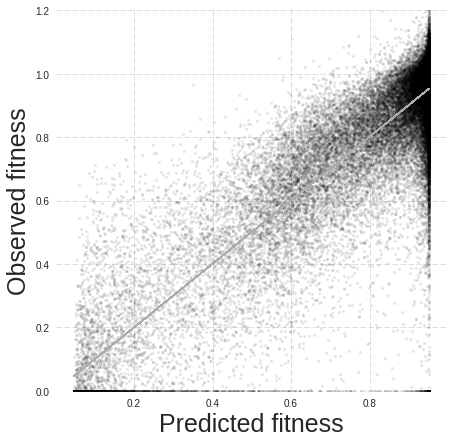

In [579]:
plt.figure(figsize = [7,7])
y = true[chunk]
x = predicted[chunk]
plt.ylim(0,1.2)

x = x[:,np.newaxis]
a, _, _, _ = np.linalg.lstsq(x, y)

plt.grid(True, ls='--', lw=0.5, alpha=0.5, dash_capstyle = 'round', c='gray')
plt.plot(x, y,'ok',alpha=0.1, ms=3)
plt.plot(x, a*x, '#abacac', lw=1, alpha=1)
plt.xlabel('Predicted fitness', fontsize=25)
plt.ylabel('Observed fitness', fontsize=25);

In [584]:
slope, intercept, r_value, p_value, std_err = stats.linregress(true[chunk],predicted[chunk])
r_value

0.83843523291467426

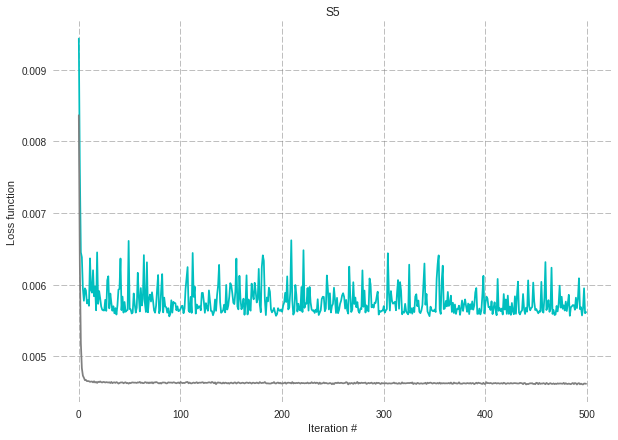

In [861]:
plt.figure(figsize=[10,7])
plt.title(chunk)
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['val_loss'], 'c')
plt.plot([x for x in range(len(hist[chunk].history['loss']))], hist[chunk].history['loss'], 'gray')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Iteration #')
plt.ylabel('Loss function');

***

# 2. Training all the segments with the chosen architecture

#### 2.1. Training

In [590]:
true = {}
predicted = {}
fitness_potential = {}
hist = {}
weights = {}
old_weights = {}
biases = {}
aa_seq = {}
unique_mutations = {}
mutList = {}

In [15]:
min_max_scaler = MinMaxScaler()
n_iter = 500

for chunk in ['S5']:
    print (chunk)
    data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)
    
    scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))
    
    x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)
    
    model = Sequential()

    model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
    model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

    opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  verbose=0)
        
    hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                            epochs=n_iter, batch_size=500, shuffle=True, verbose=0)
    
    proba = model.predict_proba(data, batch_size=500, verbose=0)
    
    weights[chunk] = model.layers[0].get_weights()[0]
    biases[chunk] = model.layers[0].get_weights()[1]
    
    true[chunk] = labels
    predicted[chunk] = min_max_scaler.inverse_transform(proba)
    predicted[chunk] = predicted[chunk].flatten()
    fitness_potential[chunk] = data.dot(weights[chunk]) + biases[chunk]

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12


***

#### 2.2. Making sure that all fitness potentials correlate negatively with fitness by multiplying weights and fitness potentials by -1

In [16]:
for chunk in chunks:

    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    if R>0:
        fitness_potential[chunk]*=-1
        weights[chunk]*=-1
        
    _,_,R,_,_ = stats.linregress(predicted[chunk],fitness_potential[chunk].flatten())
    print chunk, '\t', R

S1 	-0.776295557029
S2 	-0.814754706197
S3 	-0.824266079196
S4 	-0.848772905111
S5 	-0.561967885928
S6 	-0.803446518228
S7 	-0.840333217635
S8 	-0.827098372234
S9 	-0.935100397712
S10 	-0.915147680687
S11 	-0.899410340057
S12 	-0.682397623538


#### 2.3. Plotting

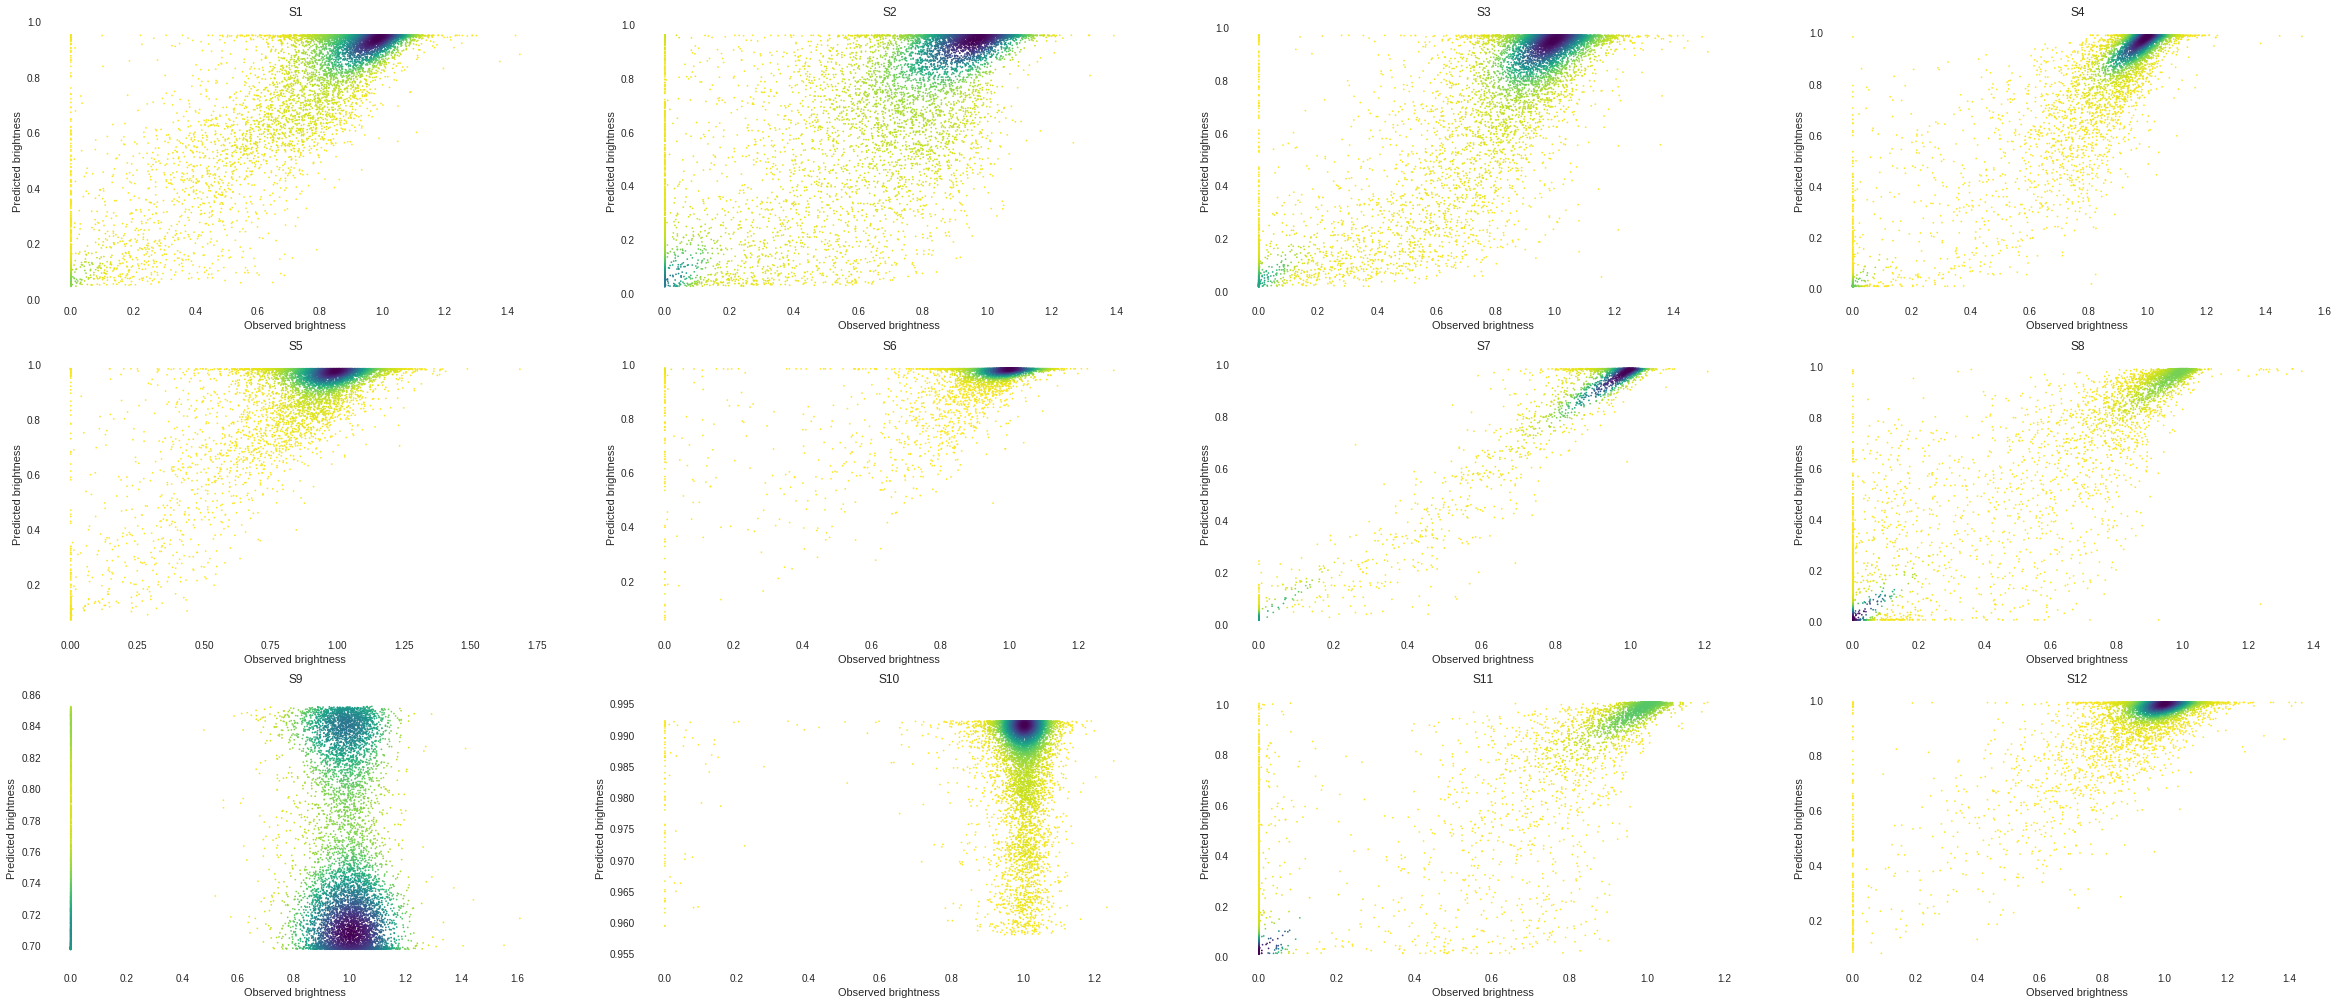

In [17]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
#     plt.ylim(0,1)
#     plt.xlim(0,1)
    density_plot(true[chunk][:10000], predicted[chunk][:10000], chunk)
    count+=1

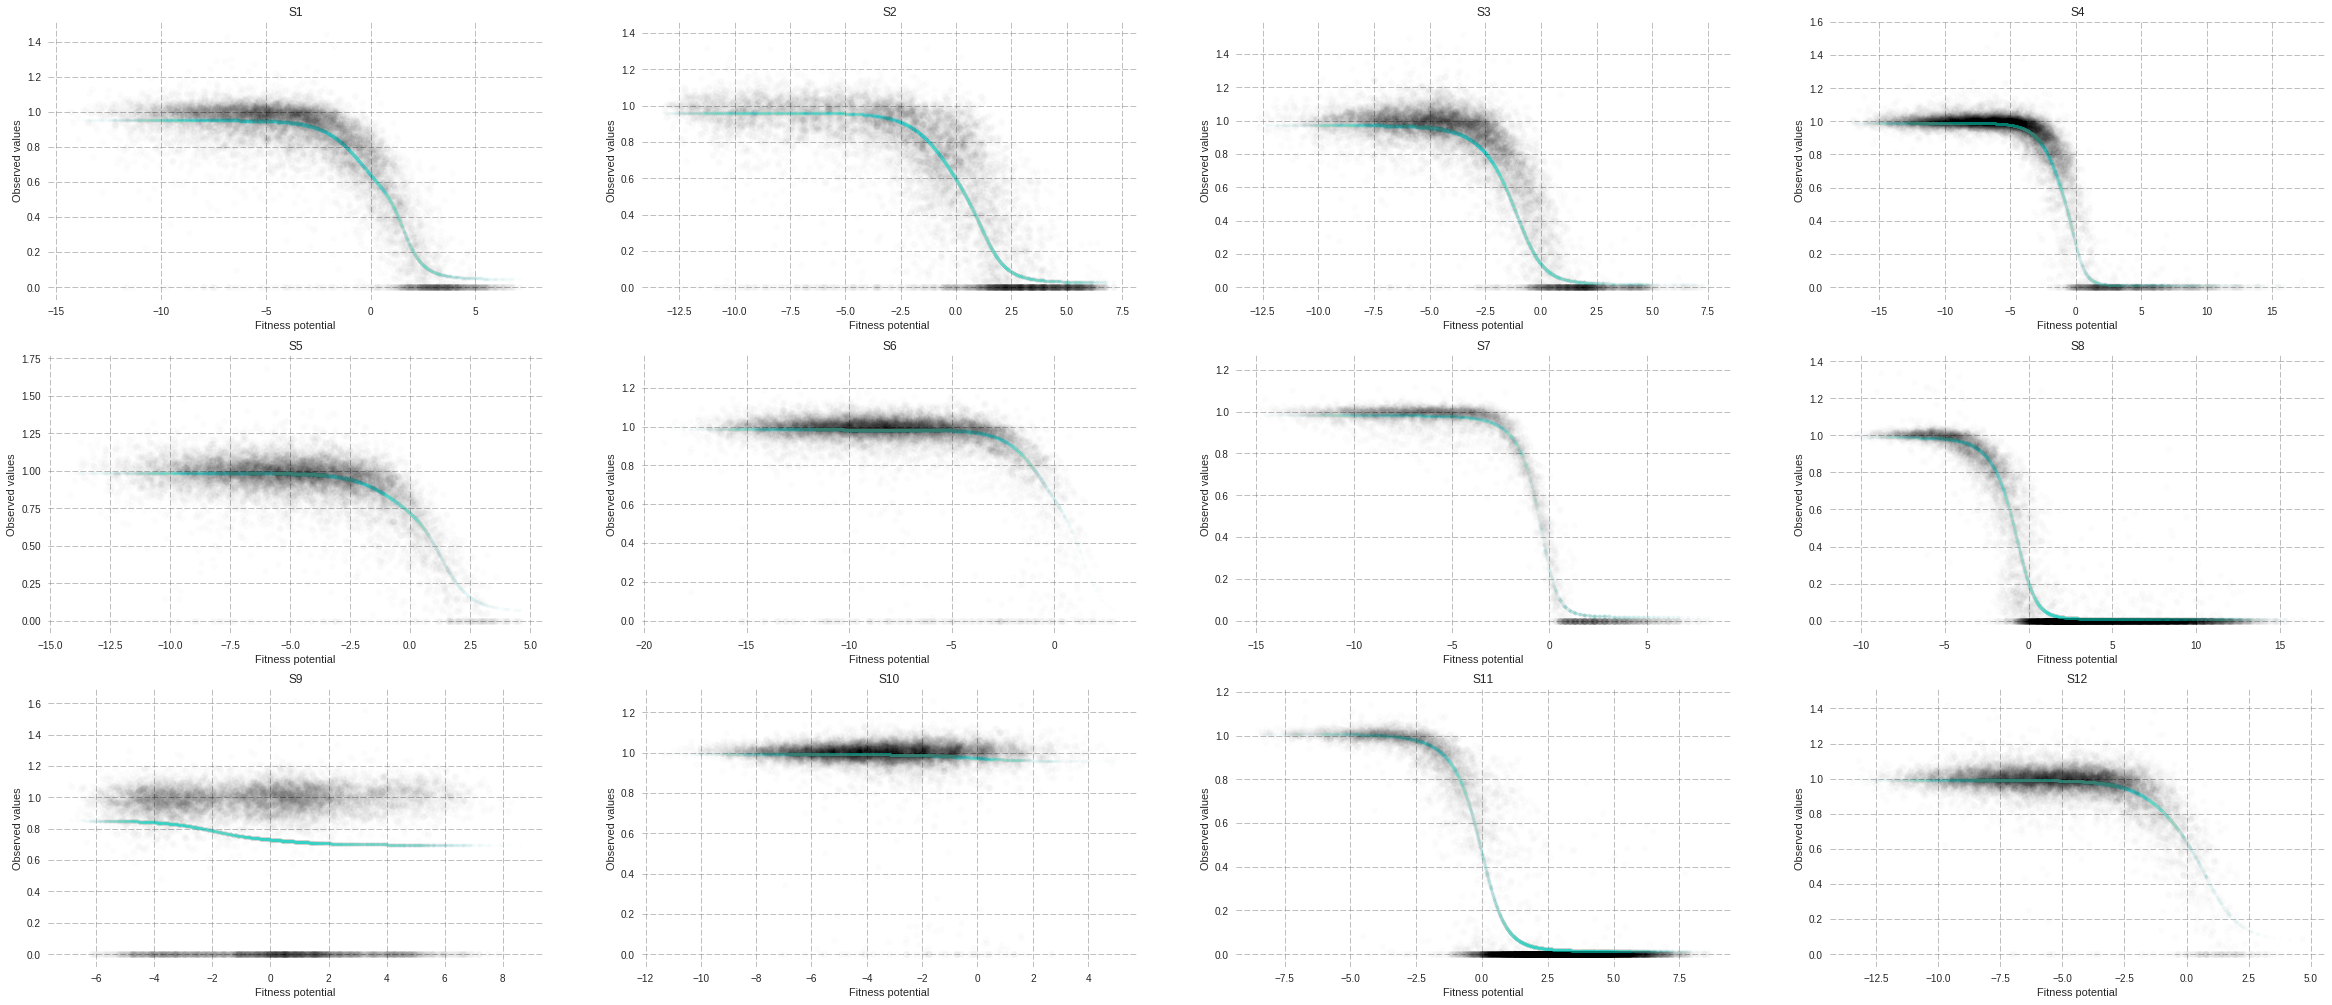

In [18]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    X = fitness_potential[chunk][:10000]
    Y = true[chunk][:10000]
    plt.plot(X, Y, 'ok', alpha = 0.01)
    plt.plot(X, predicted[chunk][:10000], '.', c='#36D1C4', alpha = 0.01)
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Fitness potential')
    plt.ylabel('Observed values')
    count+=1

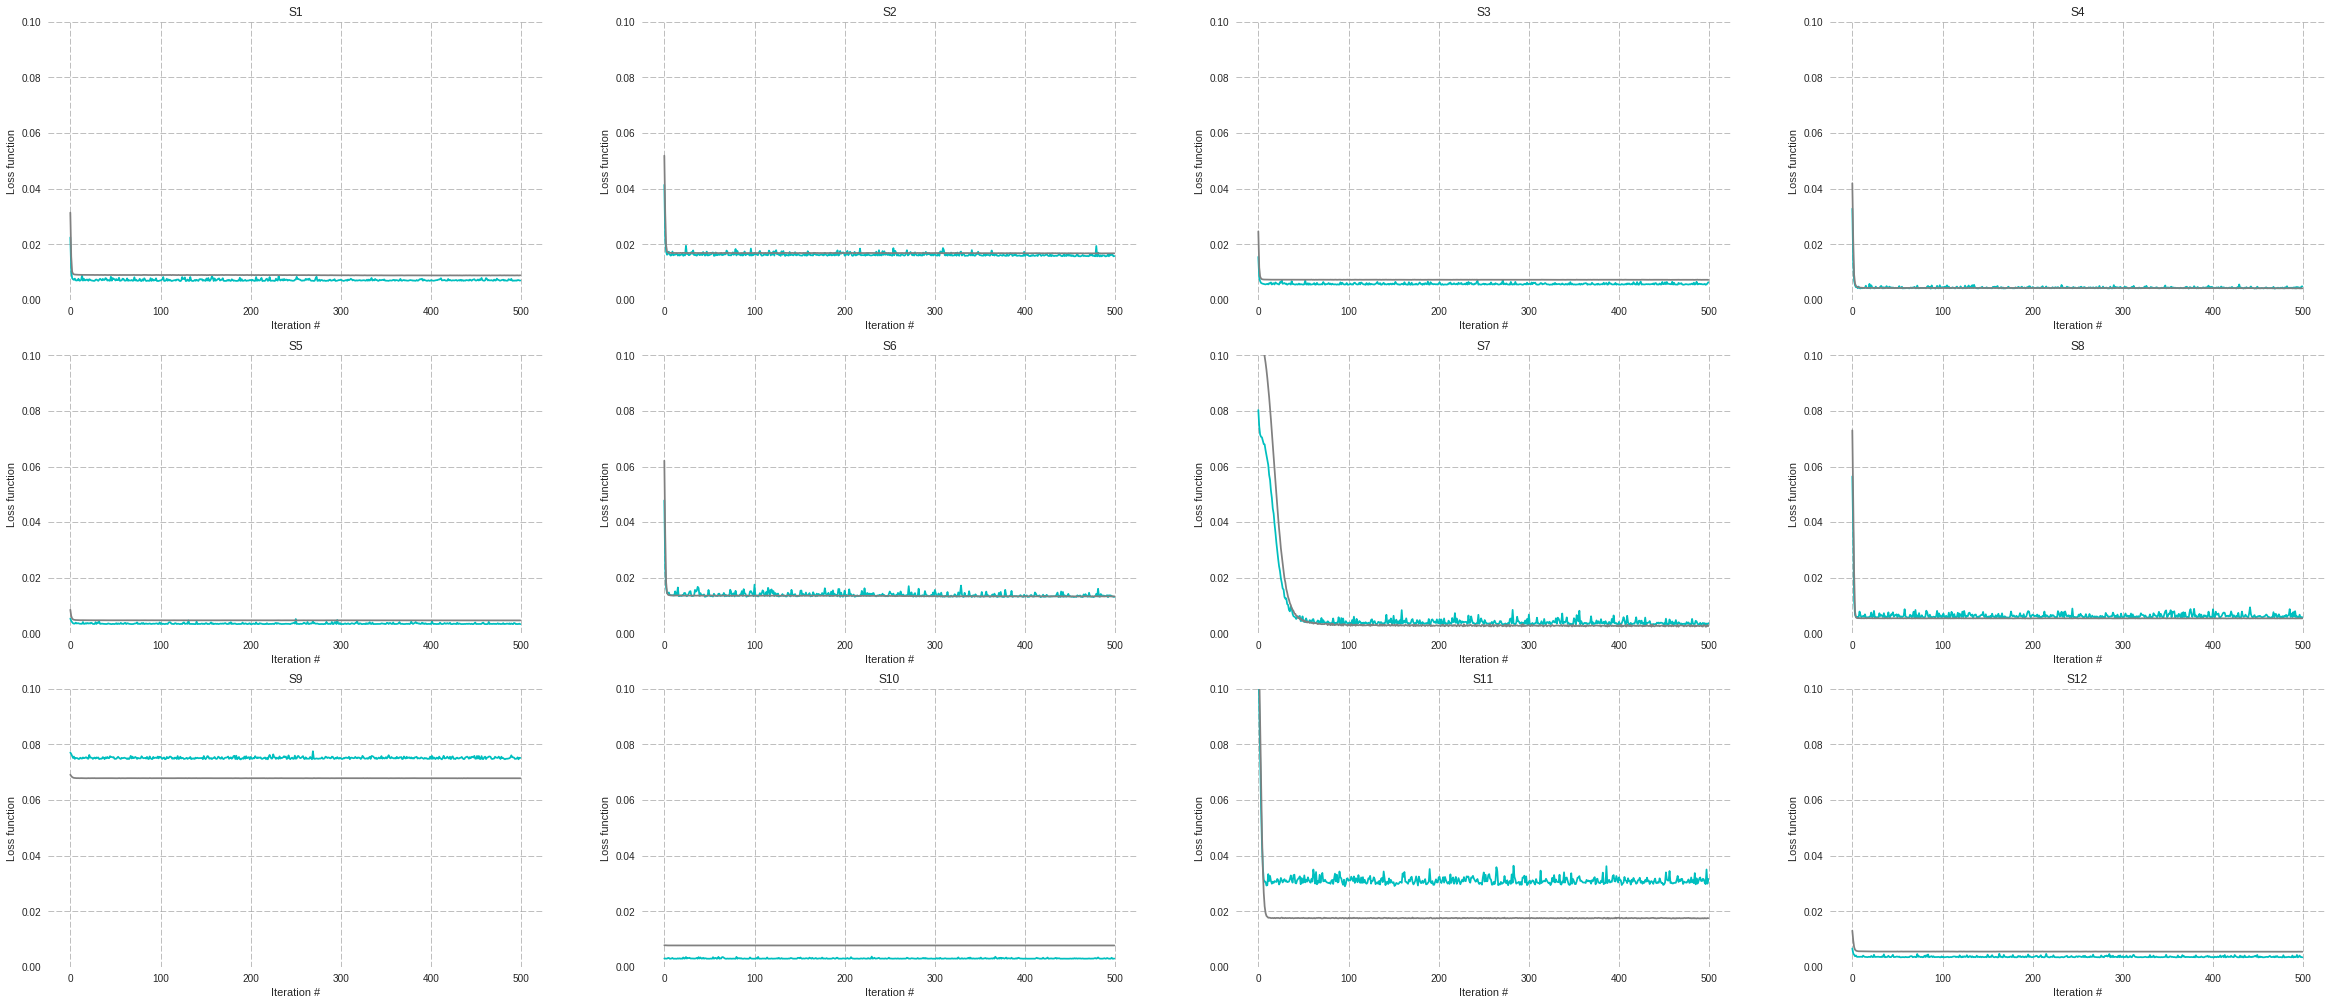

In [19]:
plt.figure(figsize=(4*5+3,3*5))
count=1
for chunk in chunks:
    plt.subplot(3,4,count)
    plt.subplots_adjust(top = 1,right=1.5)
    plt.title(chunk)
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['val_loss'], 'c')
    plt.plot([x for x in range(len(hist[chunk].history['val_loss']))], hist[chunk].history['loss'], 'gray')
    plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
    plt.xlabel('Iteration #')
    plt.ylabel('Loss function')
    plt.ylim(0, 0.1)
    count+=1

#### 2.4. Extracting residuals

In [22]:
residualsDF = {}

for chunk in chunks:
    residualsDF[chunk] = pd.DataFrame(predicted[chunk] - true[chunk], index = aa_seq[chunk])

    residualsDF[chunk]['fitnessPotential'] = fitness_potential[chunk]
    residualsDF[chunk]['observed'] = true[chunk]
    residualsDF[chunk].columns = ['predictedMinusObserved', 'fitnessPotential', 'observed']
    residualsDF[chunk].to_csv('../residuals/' + chunk + '.csv', sep=',')

#### 2.5. Extracting weights

In [23]:
weightsDF = {}

for chunk in chunks:
    weightsDF[chunk] = pd.DataFrame(weights[chunk], index = unique_mutations[chunk], columns=['weight'])
    weightsDF[chunk].to_csv('../weights/'+chunk+'.csv', sep=',')

# 3. Checking correlations and loss function

### 3.1. Correlations prediction vs observed + Lucas's values

In [24]:
r_values = []

for chunk in chunks:
    y = true[chunk]
    y_pred = predicted[chunk]
    slope, intercept, r_value, p_value, std_err = stats.linregress(y,y_pred)
    r_values.append(r_value)
    
lucas = [0.76386, 0.62877, 0.80256, 0.91289, 0.49342, 0.15075, 0.97532, 0.88078, 0.01069, 0.0096183, 0.81741, 0.54172]

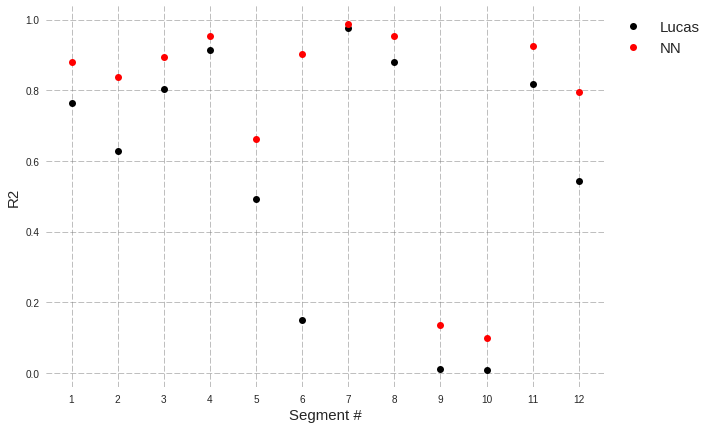

In [25]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], lucas, 'ok', label='Lucas')
plt.plot([x for x in range(1, 13)], r_values, 'or', label='NN')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1, 1))
plt.ylabel('R2', fontsize=15)
plt.xticks([x for x in range(1,13)]);

### 3.2. Mean Squared Error

In [11]:
mse = []

for chunk in chunks:
    mse.append(hist[chunk].history['loss'][-1])

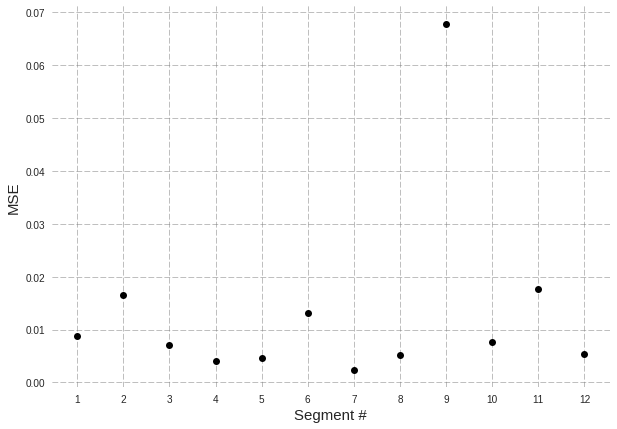

In [276]:
plt.figure(figsize=[10,7])
plt.plot([x for x in range(1, 13)], mse, 'ok')
plt.grid(True, ls='--', lw=0.5, dash_capstyle = 'round', c='gray')
plt.xlabel('Segment #', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.xticks([x for x in range(1,13)]);

# 4. Crossvalidation

### 4.1. Comparing train and test sets accuracy predictions

In [591]:
rDictTrain = {}
rDictTest = {}

In [ ]:
min_max_scaler = MinMaxScaler()
n_iter = 500

for chunk in chunks:
    
    rDictTrain[chunk] = []
    rDictTest[chunk] = []
    
    print (chunk)
    
    for i in range(10):
        print (i)
        
        data, labels, unique_mutations[chunk], aa_seq[chunk] = read_data_all_positions(chunk)

        scaledLabels = min_max_scaler.fit_transform(labels.reshape(-1,1))

        x_train, x_valid, y_train, y_valid = train_test_split(data, scaledLabels, test_size = 0.01)

        model = Sequential()

        model.add(Dense(1, input_dim=data.shape[1], activation='sigmoid', kernel_initializer='glorot_normal'))
        model.add(Dense(2, activation='sigmoid', kernel_initializer='glorot_normal'))
        model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))

        opt = optimizers.RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)

        model.compile(optimizer=opt,
                      loss='mean_squared_error',
                      verbose=0)

        hist[chunk] = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], 
                                epochs=n_iter, batch_size=500, shuffle=True, verbose=0)

        trainProba = model.predict_proba(x_train, batch_size=500, verbose=0)
        testProba = model.predict_proba(x_test, batch_size=500, verbose=0)
        
        _,_,r,_,_ = stats.linregress(y_train, trainProba.flatten())
        rDictTrain[chunk].append(r)
        
        _,_,r,_,_ = stats.linregress(y_test, testProba.flatten())
        rDictTest[chunk].append(r)        

S1
0
